# LangGraph Basic

In [1]:
!pip install langgraph

## Nodes

StateGraph에서는 노드는 일반적으로 파이썬 함수(동기 함수 또는 비동기 함수)로, 첫 번째 위치 인수는 상태(state)이며, (선택적으로) 두 번째 위치 인수는 “config”라는 구성 파라미터를 포함할 수 있습니다(예: thread_id와 같은 옵션 매개변수).

NetworkX와 유사하게, 이러한 노드를 그래프에 추가할 때 add_node 메서드를 사용합니다.

## Edges

- 에지는 로직이 어떻게 라우팅되고 그래프가 어떻게 종료를 결정하는지 정의합니다. 노드와 유사하게, 엣지는 그래프의 현재 상태를 받아 값을 반환합니다.
- 기본적으로, 이 값은 상태를 다음에 보낼 노드 또는 노드들의 이름입니다. 이러한 모든 노드는 다음 슈퍼스텝의 일부로 병렬로 실행됩니다.
- 에지를 재사용하고 싶다면, 에지의 출력을 다음 노드의 이름으로 매핑하는 딕셔너리를 선택적으로 제공할 수 있습니다.
- 항상 노드 A에서 노드 B로 이동하고 싶다면 add_edge 메서드를 직접 사용할 수 있습니다.
- 하나 이상의 에지로 선택적으로 라우팅하거나 종료를 선택적으로 하고 싶다면 add_conditional_edges 메서드를 사용할 수 있습니다.
- 노드에 다수의 출발 엣지가 있는 경우, 이러한 모든 목적지 노드는 다음 슈퍼스텝의 일부로 병렬로 실행됩니다.

In [2]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph

In [5]:
builder = StateGraph(dict)


def my_node(state: dict, config: RunnableConfig):
    print("In node: ", config["configurable"]["user_id"])
    return {"results": f"Hello, {state['input']}!"}


# The second argument is optional
def my_other_node(state: dict):
    return state


builder.add_node("my_node", my_node)
builder.add_node("other_node", my_other_node)
builder.add_edge(START, "my_node")
builder.add_edge("my_node", "other_node")
builder.add_edge("other_node", END)
graph = builder.compile()

In [6]:
graph.invoke({"input": "Will"}, {"configurable": {"user_id": "abcd-123"}})

In node:  abcd-123


{'results': 'Hello, Will!'}

백그라운드에서 함수는 [RunnableLambda](https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.base.RunnableLambda.html#langchain_core.runnables.base.RunnableLambda)로 변환되며, 이 변환은 배치 및 비동기 지원을 함수에 추가하고, 네이티브 트레이싱 및 디버깅 기능을 제공합니다.

In [7]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

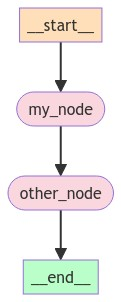

In [8]:
visualize_graph(graph)

## 상태(State) 관리

- LangGraph는 상태 관리에 두 가지 주요 개념을 도입합니다: 상태 스키마(state schemas)와 리듀서(reducers)입니다.
- 상태 스키마는 각 그래프의 노드에 전달되는 객체의 타입을 정의합니다.
- 리듀서는 노드의 출력을 현재 상태에 어떻게 적용할지를 정의합니다. 예를 들어, 새로운 대화 응답을 대화 기록에 병합하거나 여러 에이전트 노드의 출력을 평균화하는 데 리듀서를 사용할 수 있습니다. 상태 필드를 리듀서 함수로 주석 처리함으로써, 애플리케이션을 통해 데이터가 어떻게 흐르는지 정확하게 제어할 수 있습니다.

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph

### 예시1: StateA

In [12]:
class StateA(TypedDict):
    value: int


builder = StateGraph(StateA)
builder.add_node("my_node", lambda state: {"value": 1})
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)
graph = builder.compile()
graph.invoke({"value": 5})

{'value': 1}

### 예시 2: StateB

In [13]:
# reducer
def add(existing: int, new: int):
    return existing + new


class StateB(TypedDict):
    value: Annotated[int, add]


builder = StateGraph(StateB)
builder.add_node("my_node", lambda state: {"value": 1})
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)
graph = builder.compile()
graph.invoke({"value": 5})

{'value': 6}

보통 그래프의 상태 스키마(state_schema, 즉 State)로 TypedDict를 사용하지만, 상태 스키마는 거의 모든 타입이 될 수 있습니다. 따라서 다음과 같은 그래프도 완전히 유효합니다.

In [14]:
# Analogous to StateA above
builder = StateGraph(int)
builder.add_node("my_node", lambda state: 1)
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)
builder.compile().invoke(5)

1

In [15]:
# Analogous to StateB
def add(left, right):
    return left + right


builder = StateGraph(Annotated[int, add])
builder.add_node("my_node", lambda state: 1)
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)
graph = builder.compile()
graph.invoke(5)

6

## Configuration, Thread, Checkpoint

- Configuration
  - 어떤 그래프 배포에서도 런타임 시 제어할 수 있는 일부 구성 가능한 값을 원할 가능성이 높습니다. 이러한 값은 상태 변수로 취급되지 않으며, 그래프 입력과 다릅니다. 일반적인 예로는 대화의 thread_id, user_id, 사용할 LLM의 선택, 검색기에서 반환할 문서 수 등이 있습니다. 이러한 값을 상태 내에 전달할 수도 있지만, 정규 데이터 흐름과 분리하는 것이 더 좋습니다.
- Thread (스레드)
  - LangGraph의 Thread는 그래프의 개별 세션을 나타냅니다. 이러한 Thread는 애플리케이션에서 다중 대화와 다중 사용자 지원을 용이하게 하기 위해 개별 세션 내에서 상태 체크포인트를 구성합니다.
- Checkpoint (체크포인트)
  - 체크포인트는 애플리케이션과 사용자(또는 다른 사용자나 시스템) 간의 다중 턴 상호작용에서 스레드의 상태를 나타냅니다. 단일 실행 내에서 생성된 체크포인트는 이 상태에서 시작할 때 실행될 다음 노드 집합을 갖게 됩니다. 특정 실행이 끝날 때 생성된 체크포인트도 동일하지만, 전환할 다음 노드가 없다는 점이 다릅니다(그래프는 사용자 입력을 기다리고 있습니다).

In [16]:
from langgraph.checkpoint.memory import MemorySaver

In [17]:
def add(left, right):
    return left + right


class State(TypedDict):
    total: Annotated[int, add]
    turn: str


builder = StateGraph(State)
builder.add_node("add_one", lambda x: {"total": 1})
builder.add_edge(START, "add_one")
builder.add_edge("add_one", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

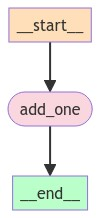

In [18]:
visualize_graph(graph)

In [19]:
thread_id = "some-thread"
config = {"configurable": {"thread_id": thread_id}}
result = graph.invoke({"total": 1, "turn": "First Turn"}, config)
result2 = graph.invoke({"turn": "Next Turn"}, config)
result3 = graph.invoke({"total": 5}, config)
result4 = graph.invoke({"total": 5}, {"configurable": {"thread_id": "new-thread-id"}})

In [20]:
result

{'total': 2, 'turn': 'First Turn'}

In [21]:
result2

{'total': 3, 'turn': 'Next Turn'}

In [22]:
result3

{'total': 9, 'turn': 'Next Turn'}

In [23]:
result4

{'total': 6}

#### 설명

1. 첫 번째 실행에서는 체크포인트가 없었기 때문에 그래프는 원시 입력으로 실행되었습니다. "total" 값은 1에서 2로 증가했고, "turn"은 "첫 번째 턴"으로 설정되었습니다.
2. 두 번째 실행에서는 사용자가 "turn"을 업데이트했지만 "total" 값은 제공하지 않았습니다! 상태에서 로드하므로, 이전 결과가 "add_one" 노드에서 1씩 증가하고, "turn"은 사용자가 제공한 값으로 덮어씌워집니다.
3. 세 번째 실행에서는 "turn"이 사용자에 의해 덮어씌워지지 않았기 때문에 체크포인트에서 로드된 그대로 유지됩니다. "total"은 사용자가 제공한 값으로 증가하며, 이는 추가 기능에 의해 감소(즉, 기존 값을 업데이트하는 데 사용됨)됩니다.
4. 네 번째 실행에서는 새로운 스레드 ID를 사용하고 있으며, 체크포인트를 찾을 수 없기 때문에 결과는 사용자가 제공한 "total"에 1을 더한 값이 됩니다.

In [24]:
graph = builder.compile()
result = graph.invoke({"total": 1, "turn": "First Turn"})
result2 = graph.invoke({**result, "turn": "Next Turn"})
result3 = graph.invoke({**result2, "total": result2["total"] + 5})
result4 = graph.invoke({"total": 5})

In [25]:
result

{'total': 2, 'turn': 'First Turn'}

In [26]:
result2

{'total': 3, 'turn': 'Next Turn'}

In [27]:
result3

{'total': 9, 'turn': 'Next Turn'}

In [28]:
result4

{'total': 6}